# Sample captions & visualize attention

In [1]:
import sys; sys.argv=['']; del sys
import numpy as np
import os
from args import get_parser
from utils.dataloader import DataLoader
from utils.config import get_opt
from utils.lang_proc import idx2word, sample, beamsearch
from model import get_model
import pickle

Using TensorFlow backend.


In [2]:
parser = get_parser()
args_dict = parser.parse_args()
args_dict.mode = 'test'
args_dict.bs = 1
args_dict.cnn_train = False

Choose model weights to load:

In [4]:
args_dict.model_file = '/work/asalvador/sat_keras/models/pap_params__weights_.e15_CIDEr0.78.h5'

Initialize model and load weights:

In [5]:
model = get_model(args_dict)

opt = get_opt(args_dict)

weights = args_dict.model_file
model.load_weights(weights)

model.compile(optimizer=opt,loss='categorical_crossentropy')

Initialize the generator to yield samples:

In [6]:
dataloader = DataLoader(args_dict)
N = args_dict.bs
val_gen = dataloader.generator('test',batch_size=args_dict.bs,train_flag=False) # N samples

Create the extractor that outputs attention weights and class probabilities

In [7]:
from keras.models import Model
att_layer = 'att_scores'
extractor = Model(input=model.input,output=[model.output,model.get_layer(att_layer).output])

Load the word vocabulary to map idxs to words:

In [8]:
vocab_file = os.path.join(args_dict.data_folder,'data',args_dict.vfile)
vocab = pickle.load(open(vocab_file,'rb'))
inv_vocab = {v:k for k,v in vocab.items()}

In [9]:
figsize = (30,30)

# parameters to manipulate attention weights
sig = 5
th = 0.3

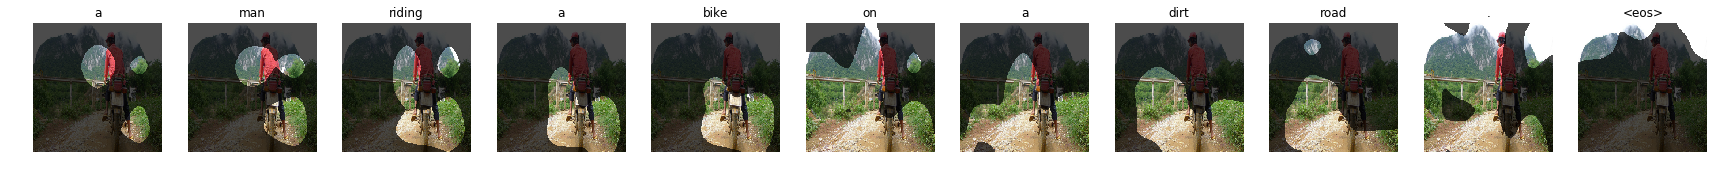

('ID:', u'COCO_val2014_000000391895.jpg')
('True:', u'a man with a red helmet on a small moped on a dirt road . <eos>')
('Gen:', u'a man riding a bike on a dirt road . <eos>')
----------


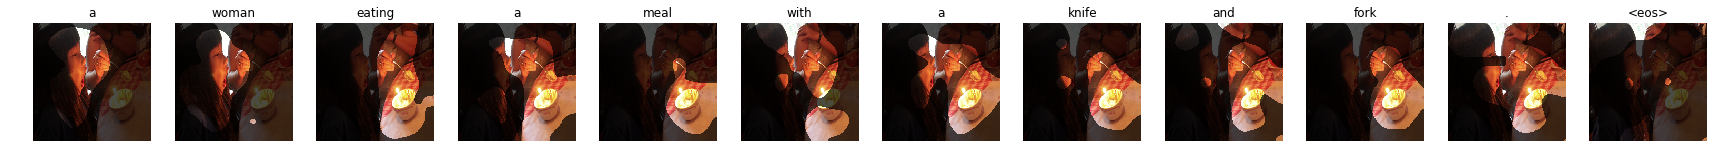

('ID:', u'COCO_val2014_000000060623.jpg')
('True:', u'a young girl <unk> with the intent of blowing out a candle . <eos>')
('Gen:', u'a woman eating a meal with a knife and fork . <eos>')
----------


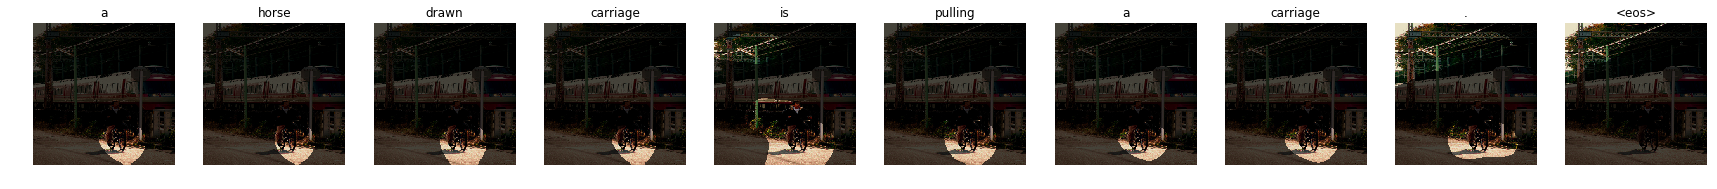

('ID:', u'COCO_val2014_000000483108.jpg')
('True:', u'a man on a bicycle riding next to a train <eos>')
('Gen:', u'a horse drawn carriage is pulling a carriage . <eos>')
----------


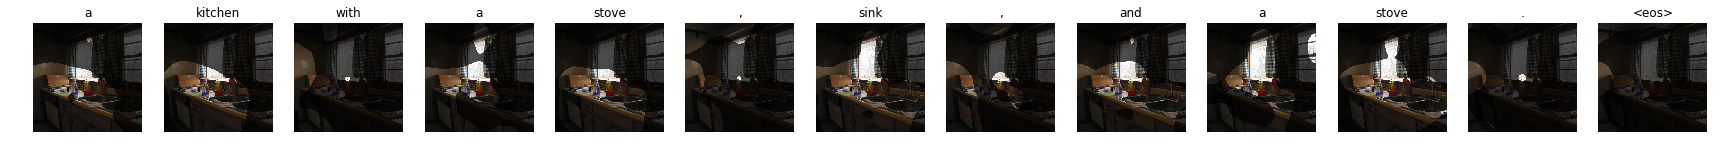

('ID:', u'COCO_val2014_000000384213.jpg')
('True:', u'a kitchen is shown with a variety of items on the counters . <eos>')
('Gen:', u'a kitchen with a stove , sink , and a stove . <eos>')
----------


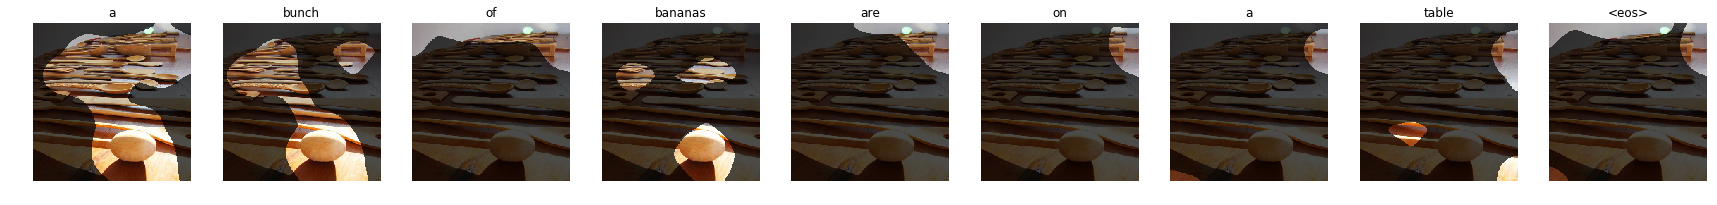

('ID:', u'COCO_val2014_000000386164.jpg')
('True:', u'a wooden ball on top of a wooden stick . <eos>')
('Gen:', u'a bunch of bananas are on a table <eos>')
----------


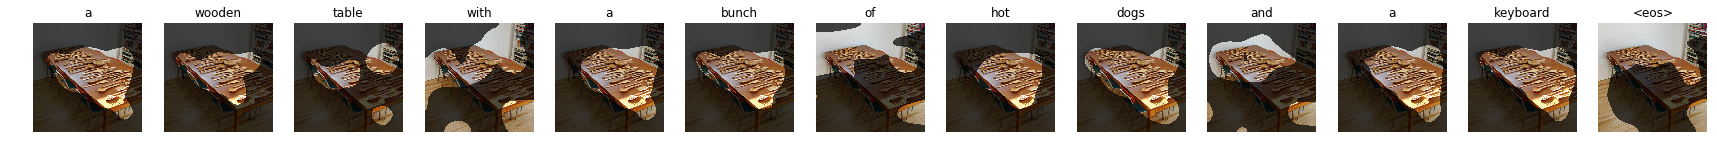

('ID:', u'COCO_val2014_000000223648.jpg')
('True:', u'multiple wooden spoons are shown on a table top . <eos>')
('Gen:', u'a wooden table with a bunch of hot dogs and a keyboard <eos>')
----------


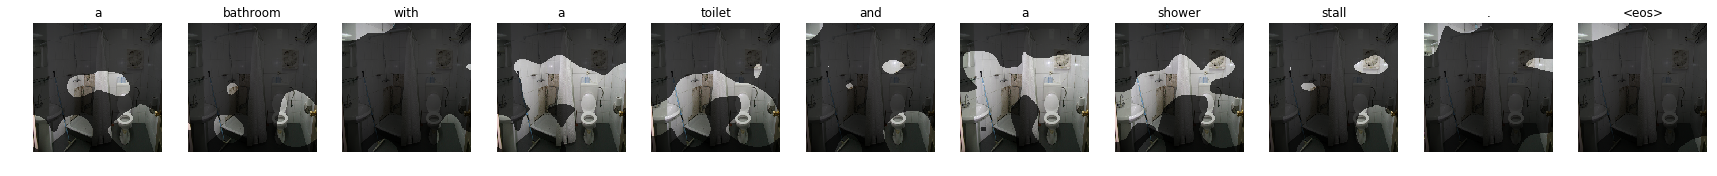

('ID:', u'COCO_val2014_000000403385.jpg')
('True:', u'a bathroom that has a broken wall in the shower . <eos>')
('Gen:', u'a bathroom with a toilet and a shower stall . <eos>')
----------


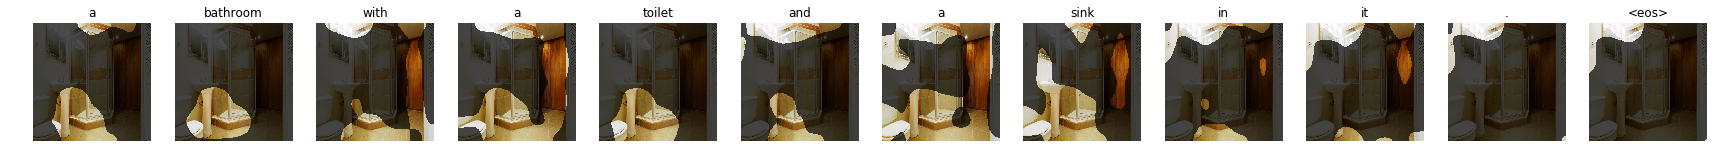

('ID:', u'COCO_val2014_000000294832.jpg')
('True:', u'a bathroom with an enclosed shower next to a sink and a toilet . <eos>')
('Gen:', u'a bathroom with a toilet and a sink in it . <eos>')
----------


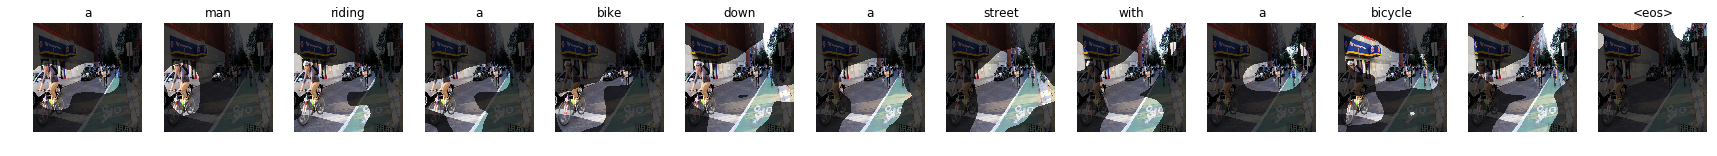

('ID:', u'COCO_val2014_000000462565.jpg')
('True:', u'people on bicycles ride down a busy street <eos>')
('Gen:', u'a man riding a bike down a street with a bicycle . <eos>')
----------


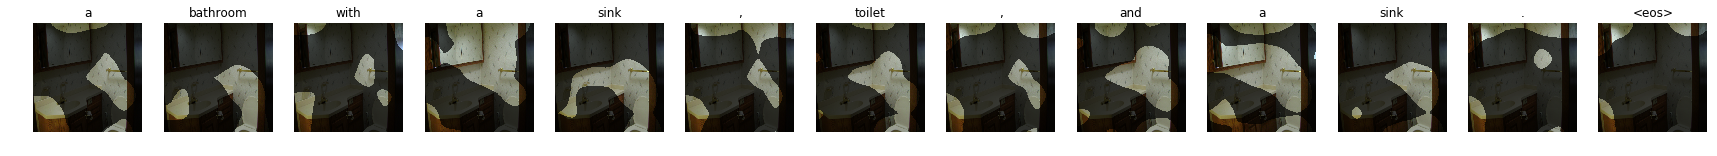

('ID:', u'COCO_val2014_000000436141.jpg')
('True:', u'the bathroom is clean and ready to be used . <eos>')
('Gen:', u'a bathroom with a sink , toilet , and a sink . <eos>')
----------


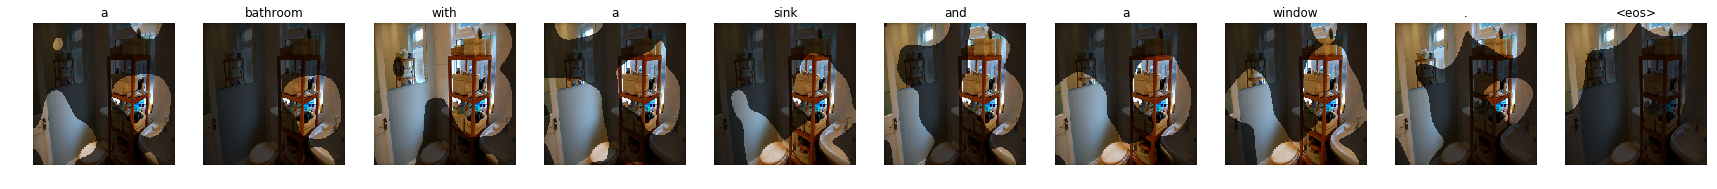

('ID:', u'COCO_val2014_000000192440.jpg')
('True:', u'a clean bathroom is seen in this image . <eos>')
('Gen:', u'a bathroom with a sink and a window . <eos>')
----------


In [10]:
from utils.im_proc import read_image
import matplotlib.pyplot as plt  
%matplotlib inline
import os
from scipy.ndimage.interpolation import zoom
from scipy.ndimage.filters import gaussian_filter
import copy

IMPATH = os.path.join(args_dict.coco_path,'images','val' + args_dict.year)
count = 0

for [im,prevs],cap,imids in val_gen:
    
    # store all attention maps here
    masks = np.zeros((args_dict.seqlen, args_dict.imsize,args_dict.imsize))
    
    # first previous word is <start> (idx 1 in vocab)
    prevs = np.ones((N,1))
    
    # store all predicted words in sequence here
    word_idxs = np.zeros((N,args_dict.seqlen))
    
    imname = imids[0]['file_name']
    img = read_image(os.path.join(IMPATH,imname),(args_dict.imsize,args_dict.imsize))

    # loop to get sequence of predicted words
    for i in range(args_dict.seqlen):

        preds,att = extractor.predict_on_batch([im,prevs]) #(N,1,vocab_size)
        
        # store predicted word and set previous word for next step
        preds = preds.squeeze()
        word_idxs[:,i] = np.argmax(preds,axis=-1)
        prevs = np.argmax(preds,axis=-1)
        prevs = np.reshape(prevs,(N,1))
        
        # attention map manipulation for display
        s_att = np.shape(att)[-1]
        att = np.reshape(att,(s_att,))
        
        if args_dict.sgate:
            s_w = att[-1] # sentinel weight
            att = att[:-1] # remove the sentinel weight from attention weights
            if s_w > 0.5:
                continue # if sentinel weight is higher, then black mask
        s = int(np.sqrt(s_att))
        att = np.reshape(att,(s,s))
        att = zoom(att,float(img.shape[0])/att.shape[-1],order=1)
        att = gaussian_filter(att,sigma=sig)
        att = (att - (np.min(att)))/(np.max(att) - np.min(att))
        att[att>th] = 1
        att[att<=th] = 0.3
        masks[i] = att

        

    # find words for predicted word idxs
    pred_caps = idx2word(word_idxs,inv_vocab)
    true_caps = idx2word(np.argmax(cap,axis=-1),inv_vocab)
    
    # display predictions with attention maps
    n_words = len(pred_caps[0])
    f, axarr = plt.subplots(1,n_words,figsize=figsize)
    for i in range(n_words):
        im = copy.deepcopy(img)
        for c in range(3):
            im[:,:,c] = im[:,:,c]*masks[i]
        axarr[i].imshow(im)
        axarr[i].axis('off')
        axarr[i].set_title(pred_caps[0][i])

    plt.show()
    
    pred_cap = ' '.join(pred_caps[0])
    true_cap = ' '.join(true_caps[0])
    
    # true captions
    print ("ID:", imids[0]['file_name'])
    print ("True:", true_cap)
    print ("Gen:", pred_cap)
    print ("-"*10)

    model.reset_states()
    count+=1
    if count > 10:
        break